In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
%matplotlib inline

# 514 Programming Assignment 2
#### Group: Rashaan, Ravi, David

Data additional information
Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52. 
Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. 
There is one Class attribute that describes the "Poker Hand". 
The order of cards is important, which is why there are 480 possible Royal Flush hands as compared to 4

#### Load dataset

In [2]:
# Column names for the dataset
# Define the column names for your dataset
columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class']

# Load your dataset
training_data = pd.read_csv('poker-hand-training-true.csv', header=None, names=columns)
testing_data = pd.read_csv('poker-hand-testing.csv', header=None, names=columns)

# Adjust the ranks of cards, specifically changing Ace from 1 to 14
def adjust_ranks(data):
    for i in range(1, 6):  # For each card in the hand
        data[f'C{i}'] = data[f'C{i}'].apply(lambda x: 14 if x == 1 else x)
    return data

# One-hot encode the suits of the cards
def one_hot_encode_suits(data):
    for i in range(1, 6):  # For each card in the hand
        data = pd.concat([data, pd.get_dummies(data[f'S{i}'], prefix=f'S{i}')], axis=1).drop([f'S{i}'], axis=1)
    return data

# Apply preprocessing steps
def preprocess_data(data):
    data = adjust_ranks(data)
    data = one_hot_encode_suits(data)
    return data

training_data_preprocessed = preprocess_data(training_data)
testing_data_preprocessed = preprocess_data(testing_data)


#### Final Preprocessed DATA

In [3]:
training_data_preprocessed.head()

,C1,C2,C3,C4,C5,Class,S1_1,S1_2,S1_3,S1_4,...,S3_3,S3_4,S4_1,S4_2,S4_3,S4_4,S5_1,S5_2,S5_3,S5_4
0,10,11,13,12,14,9,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,11,13,10,12,14,9,False,True,False,False,...,False,False,False,True,False,False,False,True,False,False
2,12,11,13,10,14,9,False,False,True,False,...,True,False,False,False,True,False,False,False,True,False
3,10,11,14,13,12,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
4,14,13,12,11,10,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True


In [4]:
testing_data_preprocessed.head()

,C1,C2,C3,C4,C5,Class,S1_1,S1_2,S1_3,S1_4,...,S3_3,S3_4,S4_1,S4_2,S4_3,S4_4,S5_1,S5_2,S5_3,S5_4
0,14,13,4,3,12,0,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,12,2,11,5,5,1,False,False,True,False,...,True,False,False,False,False,True,False,True,False,False
2,9,6,4,2,9,1,True,False,False,False,...,False,False,False,False,True,False,False,False,True,False
3,4,13,13,14,6,1,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,10,7,2,11,9,0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True


In [5]:
training_data_preprocessed.describe()

,C1,C2,C3,C4,C5,Class
count,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000
mean,8.025470,8.045982,7.999160,7.973211,7.986725,0.621152
std,3.746958,3.758723,3.743223,3.758728,3.748488,0.788361
min,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000
50%,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000
75%,11.000000,11.000000,11.000000,11.000000,11.000000,1.000000
max,14.000000,14.000000,14.000000,14.000000,14.000000,9.000000


# Artificial Neural Network (ANN) - Part B

In [6]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,classification_report,confusion_matrix

2024-03-31 16:17:40.193778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### PREPARE THE TRAINING AND TESTING SETS

In [7]:
x_train = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train = pd.DataFrame(training_data_preprocessed['Class'])

x_test = testing_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test = pd.DataFrame(testing_data_preprocessed['Class'])

##### Adjust the classes such that each card is mapped to either BAD, GOOD, or GREAT then one-hot encode classes

In [8]:
def adjust_class(data):
        #BAD
        data['Class'] = data['Class'].apply(lambda x: 0 if x == 0 else x)
        data['Class'] = data['Class'].apply(lambda x: 0 if x == 1 else x)
        data['Class'] = data['Class'].apply(lambda x: 0 if x == 2 else x)
        data['Class'] = data['Class'].apply(lambda x: 0 if x == 3 else x)
        #GOOD
        data['Class'] = data['Class'].apply(lambda x: 4 if x == 4 else x)
        data['Class'] = data['Class'].apply(lambda x: 4 if x == 5 else x)
        data['Class'] = data['Class'].apply(lambda x: 4 if x == 6 else x)
        #GREAT
        data['Class'] = data['Class'].apply(lambda x: 9 if x == 7 else x)
        data['Class'] = data['Class'].apply(lambda x: 9 if x == 8 else x)
        data['Class'] = data['Class'].apply(lambda x: 9 if x == 9 else x)
        return data

def one_hot_encode_classes(data):
    data = pd.get_dummies(data,columns=['Class'])
    return data

In [9]:
x_train_float = np.asarray(x_train).astype('float32') 

x_test_float = np.asarray(x_test).astype('float32') 

y_train_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_train))).astype('float32')
y_train_one_hot = pd.DataFrame(y_train_one_hot, columns=['Bad','Good','Great'])

y_test_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_test))).astype('float32')
y_test_one_hot = pd.DataFrame(y_test_one_hot, columns=['Bad','Good','Great'])

#### Display one-hot classifications of output card classes

In [10]:
y_train_one_hot.describe()

,Bad,Good,Great
count,25010.000000,25010.000000,25010.000000
mean,0.992043,0.007317,0.000640
std,0.088838,0.085243,0.025277
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [11]:
y_train_one_hot.shape

(25010, 3)

In [12]:
y_test_one_hot.describe()

,Bad,Good,Great
count,1000000.00000,1000000.000000,1000000.000000
mean,0.99245,0.007305,0.000245
std,0.08628,0.084891,0.015649
min,0.00000,0.000000,0.000000
25%,1.00000,0.000000,0.000000
50%,1.00000,0.000000,0.000000
75%,1.00000,0.000000,0.000000
max,1.00000,1.000000,1.000000


In [13]:
y_test_one_hot.shape

(1000000, 3)

#### CREATE OUR ANN MODEL SKELETON 

#### Function to run Five-Fold CV on ANN 

In [14]:
def five_fold_CV(x_train,y_train,x_test,y_test,runs,batch,v):
    #MODEL
    model = Sequential()
    model.add(Dense(units=25,use_bias=True,kernel_initializer='ones',bias_initializer='ones',activation='sigmoid'));
    model.add(Dense(3,activation='softmax'))
    my_optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=my_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=25,verbose=1)
    
    ### FOLDS ####
    folds = StratifiedKFold(n_splits=5)
    cv_folds = folds.split(x_train,y_train)
    x_,y_,x_t,y_t = [],[],[],[]
    for i, (train_index, test_index) in enumerate(cv_folds):
        temp_x,temp_y = copy.deepcopy(x_train.iloc[train_index]),copy.deepcopy(y_train.iloc[train_index])
        temp_x_test,temp_y_test = copy.deepcopy(x_train.iloc[test_index]),copy.deepcopy(y_train.iloc[test_index])
        x_.append(temp_x)
        y_.append(temp_y)
        x_t.append(temp_x_test)
        y_t.append(temp_y_test)
        
    #FOLD 1
    x_train_float_fold1 = np.asarray(x_[0]).astype('float32') 

    y_train_float_fold1 = np.asarray(one_hot_encode_classes(adjust_class(y_[0]))).astype('float32')
    y_train_float_fold1 = pd.DataFrame(y_train_float_fold1, columns=['Bad','Good','Great'])
    
    x_test_float_fold1 = np.asarray(x_t[0]).astype('float32') 

    y_test_float_fold1 = np.asarray(one_hot_encode_classes(adjust_class(y_t[0]))).astype('float32')
    y_test_float_fold1 = pd.DataFrame(y_test_float_fold1, columns=['Bad','Good','Great'])

    #FOLD 2
    x_train_float_fold2 = np.asarray(x_[1]).astype('float32') 

    y_train_float_fold2 = np.asarray(one_hot_encode_classes(adjust_class(y_[1]))).astype('float32')
    y_train_float_fold2 = pd.DataFrame(y_train_float_fold2, columns=['Bad','Good','Great'])
    
    x_test_float_fold2 = np.asarray(x_t[1]).astype('float32') 

    y_test_float_fold2 = np.asarray(one_hot_encode_classes(adjust_class(y_t[1]))).astype('float32')
    y_test_float_fold2 = pd.DataFrame(y_test_float_fold2, columns=['Bad','Good','Great'])

    #FOLD 3
    x_train_float_fold3 = np.asarray(x_[2]).astype('float32') 

    y_train_float_fold3 = np.asarray(one_hot_encode_classes(adjust_class(y_[2]))).astype('float32')
    y_train_float_fold3 = pd.DataFrame(y_train_float_fold3, columns=['Bad','Good','Great'])
    
    x_test_float_fold3 = np.asarray(x_t[2]).astype('float32') 

    y_test_float_fold3 = np.asarray(one_hot_encode_classes(adjust_class(y_t[2]))).astype('float32')
    y_test_float_fold3 = pd.DataFrame(y_test_float_fold3, columns=['Bad','Good','Great'])

    #FOLD 4
    x_train_float_fold4 = np.asarray(x_[3]).astype('float32') 

    y_train_float_fold4 = np.asarray(one_hot_encode_classes(adjust_class(y_[3]))).astype('float32')
    y_train_float_fold4 = pd.DataFrame(y_train_float_fold4, columns=['Bad','Good','Great'])
    
    x_test_float_fold4 = np.asarray(x_t[3]).astype('float32') 

    y_test_float_fold4 = np.asarray(one_hot_encode_classes(adjust_class(y_t[3]))).astype('float32')
    y_test_float_fold4 = pd.DataFrame(y_test_float_fold4, columns=['Bad','Good','Great'])

    #FOLD 5
    x_train_float_fold5 = np.asarray(x_[4]).astype('float32') 

    y_train_float_fold5 = np.asarray(one_hot_encode_classes(adjust_class(y_[4]))).astype('float32')
    y_train_float_fold5 = pd.DataFrame(y_train_float_fold5, columns=['Bad','Good','Great']) 
    
    x_test_float_fold5 = np.asarray(x_t[4]).astype('float32') 

    y_test_float_fold5 = np.asarray(one_hot_encode_classes(adjust_class(y_t[4]))).astype('float32')
    y_test_float_fold5 = pd.DataFrame(y_test_float_fold5, columns=['Bad','Good','Great'])
    
    ### TESTING ###
    loss = []
    scores = []
    
    x_test_float = np.asarray(x_test).astype('float32')
    x_test = x_test_float
    
    y_test_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_test))).astype('float32')
    y_test_one_hot = pd.DataFrame(y_test_one_hot, columns=['Bad','Good','Great'])
    y_test = y_test_one_hot
    
    #First CV FOLD
    print("First CV FOLD")
    x=x_train_float_fold1
    y=y_train_float_fold1
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold1,y_test_float_fold1),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold1,y_test_float_fold1,verbose=0))
    model.save('first_cv.keras')
    del model #clear cache
    
    #Second CV Fold
    print("\nSecond CV FOLD")
    model = load_model('first_cv.keras')
    x=x_train_float_fold2
    y=y_train_float_fold2
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold2,y_test_float_fold2),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold2,y_test_float_fold2,verbose=0))
    model.save('second_cv.keras')
    del model #clear cache
    
    #Third CV Fold
    print("\nThird CV FOLD")
    model = load_model('second_cv.keras')
    x=x_train_float_fold3
    y=y_train_float_fold3
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold3,y_test_float_fold3),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold3,y_test_float_fold3,verbose=0))
    model.save('third_cv.keras')
    del model #clear cache
    
    #Fourth CV Fold
    print("\nFourth CV FOLD")
    model = load_model('third_cv.keras')
    x=x_train_float_fold4
    y=y_train_float_fold4
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold4,y_test_float_fold4),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold4,y_test_float_fold4,verbose=0))
    model.save('fourth_cv.keras')
    del model #clear cache
    
    #Fifth CV Fold
    print("\nFifth CV FOLD")
    model = load_model('fourth_cv.keras')
    x=x_train_float_fold5
    y=y_train_float_fold5
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold5,y_test_float_fold5),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold5,y_test_float_fold5,verbose=0))
    model.save('fifth_cv.keras')
    
    return model,loss,scores

In [15]:
model,loss,scores = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0)

First CV FOLD

Second CV FOLD

Third CV FOLD

Fourth CV FOLD
Epoch 44: early stopping

Fifth CV FOLD


<Axes: >

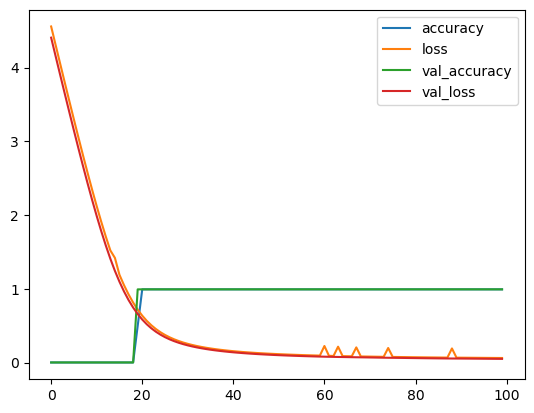

In [16]:
loss[0].plot()

<Axes: >

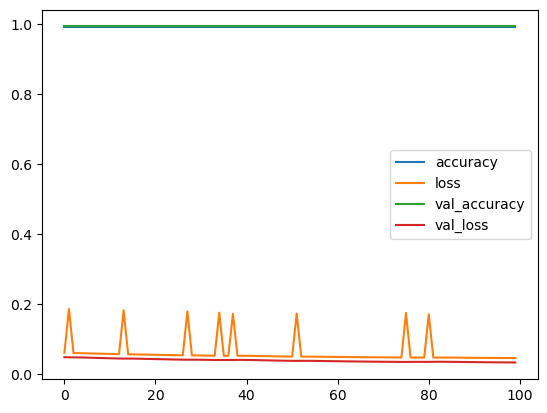

In [17]:
loss[1].plot()

<Axes: >

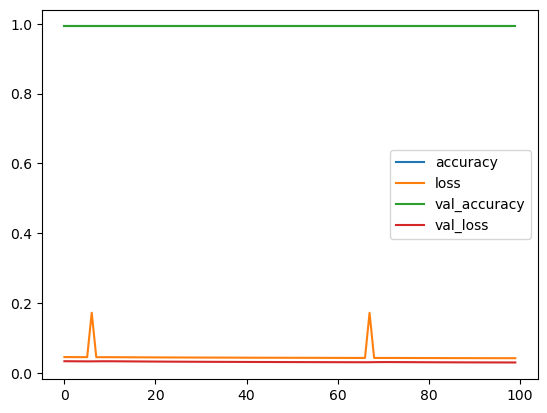

In [18]:
loss[2].plot()

<Axes: >

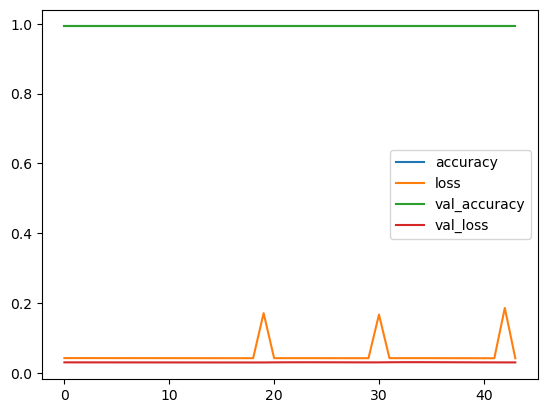

In [19]:
loss[3].plot()

<Axes: >

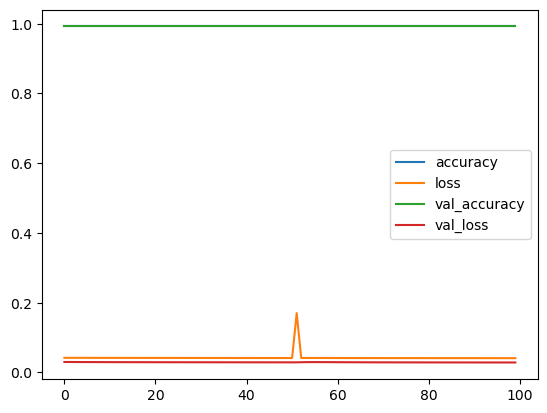

In [20]:
loss[4].plot()

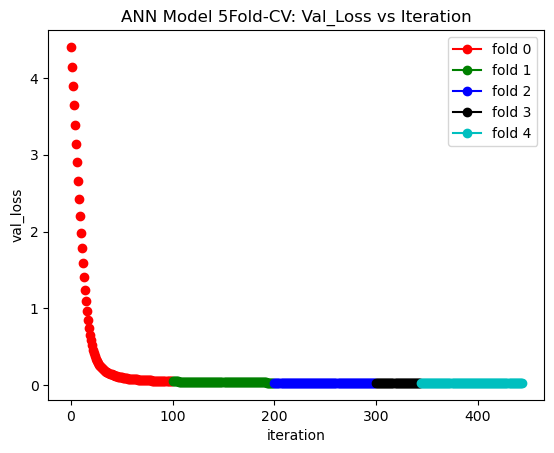

In [21]:
def plot_cv_loss(loss):
    colors = ['r','g','b','k','c','m']
    x,y,count = 0,0,0
    for i in range(len(loss)):
        for j in range(len(loss[i]['val_loss'])):
            x = count
            y = loss[i]['val_loss'][j]
            count+=1
            if(j==0):
                plt.plot(x,y,colors[i],ls='-',marker='o',label='fold '+str(i))
            else:
                plt.plot(x,y,colors[i],ls='-',marker='o')
    plt.title("ANN Model 5Fold-CV: Val_Loss vs Iteration")
    plt.xlabel("iteration")
    plt.ylabel("val_loss")
    plt.legend(loc="upper right")
    plt.show()
    
plot_cv_loss(loss)

#### Use the best model to train on the entire training dataset

In [22]:
model = load_model('fifth_cv.keras')

In [23]:
### TRAIN
x = np.asarray(x_train).astype('float32')

y_train_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_train))).astype('float32')
y = pd.DataFrame(y_train_one_hot, columns=['Bad','Good','Great'])

#### TEST
x_test_float = np.asarray(x_test).astype('float32')
x_test = x_test_float
    
y_test_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_test))).astype('float32')
y_test_one_hot = pd.DataFrame(y_test_one_hot, columns=['Bad','Good','Great'])
y_test = y_test_one_hot

early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=25,verbose=1)
model.fit(x=x,y=y,epochs=500,validation_data=(x_test,y_test),batch_size=5000,callbacks=[early_stop],verbose=1)
loss.append(pd.DataFrame(model.history.history))
scores.append(model.evaluate(x_test,y_test,verbose=0))
model.save('final_model_entire_train.keras')

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9924 - loss: 0.0457 - val_accuracy: 0.9924 - val_loss: 0.0470
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9920 - loss: 0.0474 - val_accuracy: 0.9924 - val_loss: 0.0470
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9922 - loss: 0.0465 - val_accuracy: 0.9924 - val_loss: 0.0469
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9921 - loss: 0.0470 - val_accuracy: 0.9924 - val_loss: 0.0469
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9916 - loss: 0.0498 - val_accuracy: 0.9924 - val_loss: 0.0469
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9919 - loss: 0.0484 - val_accuracy: 0.9924 - val_loss: 0.0469
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9920 - loss: 0.0478 - val_accuracy: 0.9924 - val_loss: 0.0469
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9919 - loss: 0.0480 - val_accuracy: 0.9924 - val_l